<a href="https://colab.research.google.com/github/williamedwardhahn/OISC/blob/main/Hahn_MPCR_OISC_Logo_October_1st_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MPCR OISC

In [ ]:
# Thing <- Name of the thing <- Name of the Name of the thing

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 4096

def load_from_string(content):

    content += '''PS'''

    lines = [line.split('#')[0].strip() for line in content.split("\n") if line.split('#')[0]]

    C = np.zeros(N, dtype='object')
    D = {}
    i = 0
    for line in lines:

        tokens = line.strip().replace(',', ' ').split()
        D[tokens[0]] = i
        code = [D[token] if token in D else int(token) for token in tokens[1:]]

        if code:
            C[i] = i + 1
            C[i+1:i+1+len(code)] = code
            i += len(code) + 1
        else:
            i += 1

    return C, D



def compile_program(X):
    program = []
    for x in X.split(' '):
        if x.lstrip("-").isdigit():
            program += [int(x), D['L'], D['L'], D['S']]
        elif "," in x:
            a, b = map(lambda y: int(y) if y.lstrip("-").isdigit() else D[y], x.split(','))
            program += [a, b]
        else:
            program += [D[x], D['W']]
    program += [0, D['L'], D['L'], D['IP']]
    return program



def setup(program):
    program = compile_program(program)
    M = np.zeros(N, dtype=int)
    M[:len(C)] = C
    M[D["PS"]:D["PS"] + len(program)] = program
    M[D["IP"]] = D["PS"]
    M[D["SL"]] = 0
    M[D["WL"]] = 0
    return M



def run(M):

    IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])


    while M[IP] > 0:

        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
        i,j = M[a]    , M[b]     # copy from address i paste in address j


        if i == S and j == L:
            M[L] = i
        elif i == W and j == L:
            M[L] = i

        elif j == L:
            M[L] = i

        elif i == S:
            M[j] = M[SL + M[SL]]
            M[SL] -= 1
        elif j == S:
            M[SL] += 1
            M[SL + M[SL]] = M[i]

        elif i == W:
            M[j] = M[WL + M[WL]]
            M[WL] -= 1
        elif j == W:
            M[WL] += 1
            M[WL + M[WL]] = M[0]
            M[0] = M[i]

        elif i == P:
            M[j] = M[M[A]]
        elif j == P:
            M[M[A]] = M[i]

        else:
            M[j] = M[i]


        #Memory Mapped ALU
        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]


    return M



code_ai = """
IP    # Instruction Pointer
A     # ALU Operand Register
B     # ALU Operand Register
C     # AUX Register
X     # AUX Register
Y     # AUX Register
Z     # AUX Register
I     # Loop Index
J     # Loop Index
K     # Loop Index
Add
Sub
Mult
Div
Equal
Greater
Lesser
L
S
W
P
Halt 0,L L,0
Push A,S W,0
Peek S,A A,S W,0
Pop S,A W,0
Drop S,C W,0
Dup S,A A,S A,S W,0
Swap S,B S,A B,S A,S W,0
Zero 0,L L,S W,0
One 1,L L,S W,0
+ S,B S,A Add,S W,0
- S,B S,A Sub,S W,0
* S,B S,A Mult,S W,0
/ S,B S,A Div,S W,0
Not S,A -1,L L,B Mult,A 1,L L,B Add,S W,0
Negate S,A -1,L L,B Mult,S W,0
Rot S,C S,B S,A C,S A,S B,S W,0
Continue A,A W,0
Branch Dup,W Not,W Rot,W *,W Rot,W *,W +,W S,A A,W W,0
If Continue,S Rot,W Branch,W W,0
Square Dup,W *,W W,0
Cube Dup,W Square,W *,W W,0
Fourth Square,W Square,W A,A W,0
Double Dup,W +,W W,0
-- S,A 1,L L,B Sub,S W,0
++ S,A 1,L L,B Add,S W,0
== S,B S,A Equal,S W,0
> S,B S,A Greater,S W,0
< S,B S,A Lesser,S W,0
Word1 Double,W W,0
Apple 0
Orange 0
! S,A S,P W,0
@ S,A P,S W,0
Halve S,A 2,L L,B Div,S W,0
Over S,B S,A A,S B,S A,S W,0
Mod S,Y S,X X,A Y,B Div,A Mult,B X,A Sub,S W,0
I-- I,S --,W S,I W,0
I++ I,S ++,W S,I W,0
I--Y0 I,S --,W S,I Y,0 W,0
Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0
SL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
WL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
Text 3 97 98 99 0  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
"""


C, D = load_from_string(code_ai) # Codes, Dictionary



In [ ]:

# Test data
number_test_programs = [(f"{i}", [i]) for i in range(100)]

for i, (program, expected_answer) in enumerate(number_test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

test_programs = [
    ("10 11 +", [21]),                                     # Add 10 and 11
    ("10 3 -", [7]),                                       # Subtract 3 from 10
    ("8 9 *", [72]),                                       # Multiply 8 by 9
    ("10 2 /", [5]),                                       # Divide 10 by 2
    ("10 3 >", [1]),                                       # Check if 10 is greater than 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("1 Not", [0]),                                        # Logical NOT of 1
    ("5 Fourth", [625]),                                   # Raise 5 to the power of 4
    ("8 9 * 7 + Fourth", [38950081]),                      # Multiply 8 and 9, add 7, and raise the result to the power of 4
    ("0 Not", [1]),                                        # Logical NOT of 0
    ("-5 Negate", [5]),                                    # Negate -5
    ("6 --", [5]),                                         # Decrement 6 by 1
    ("3 Double", [6]),                                     # Double the value 3
    ("3 5 -", [-2]),                                       # Subtract 5 from 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("0 5 >", [0]),                                        # Check if 0 is greater than 5
    ("6 5 >", [1]),                                        # Check if 6 is greater than 5
    ("5 Double,S Fourth,S One Branch", [625]),             # Double 5, raise it to the power of 4, and branch based on 1 (true)
    ("5 Double,S Fourth,S Zero Branch", [10]),             # Double 5, raise it to the power of 4, and branch based on 0 (false)
    ("5 Continue,S Fourth,S One Branch 22 1 +", [625,23]), # Continue with operations, raise 5 to the power of 4, branch based on 1, add 22 and 1
    ("4 Halve", [2]),                                      # Divide 4 by 2
    ('2 4 + 3 -', [3]),                                    # Simple arithmetic
    ('2 2 2 2 2 + + + +', [10]),                           # Stacking operations
    ('5 2 * 10 /', [1]),                                   # Multiplication followed by division
    ('5 2 <', [0]),                                        # Lesser than check
    ('2 5 <', [1]),                                        # Lesser than check
    ('5 5 ==', [1]),                                       # Equality check
    ('5 3 ==', [0]),                                       # Non-equality check
    ('5 3 > 4 +', [5]),                                    # Greater than check with subsequent addition
    ('6 3 / 2 *', [4]),                                    # Division followed by multiplication
    ('2 5 > 3 4 + +', [7]),                                # Greater than check with subsequent operations
    ("10 3 Over", [10, 3, 10]),
    ("3 Cube", [27]),
    ("10 3 6 Rot", [6, 10, 3]),
    ("7 4 Mod", [3]),
    ("10 3 Mod", [1]),
    ("5 Continue,S Double,S One Branch", [10]),
    ("5 Double,S One If", [10]),
    ("5 Double,S Zero If", [5]),
    ("2 Word1,S 10 Loop", [1024]),
    ("2 Word1,S 8 Loop", [256]),
    ("5 S,Apple 10 Drop,W Apple,S", [5]),
    ]

for i, (program, expected_answer) in enumerate(test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

print('All tests passed.')

All tests passed.


In [ ]:
# Debug View
D2 = {v: k for k, v in D.items()} #invert D
print(f"{'Index':<8}{'Name':<8}{'Value':>8}")
for i in range(len(C)-1500):
    if i in D2:
        print(f"{i:<8}{D2[i]:<8}{C[i]:>8}")
    else:
        print(f"{i:<8}{'':<8}{C[i]:>8}")

In [ ]:
D['Text']
M[D['Text']]
M[M[D['Text']]]
chr(97)
output = ''.join([chr(i) for i in M[M[D['Text']]+1:M[D['Text']]+1+M[M[D['Text']]]]])
print(output)

abc


In [ ]:
# plt.imshow(M.reshape(50,50))

In [ ]:
code0 = code_ai

In [ ]:
n = 50

In [ ]:
display = "DL" + n*n*" 0" + "\n"

In [ ]:
code0 = code_ai + display

In [ ]:
new_code = '''
TurtleX
TurtleY
TurtleI
TurtleC
TurtleN
TurtleX-- TurtleX,S --,W S,TurtleX W,0
TurtleX++ TurtleX,S ++,W S,TurtleX W,0
TurtleY-- TurtleY,S --,W S,TurtleY W,0
TurtleY++ TurtleY,S ++,W S,TurtleY W,0
TurtleI++ TurtleI,S ++,W S,TurtleI W,0
Paint S,A TurtleC,P Drop,W W,0
UpdateTurtleI TurtleY,S TurtleN,S *,W TurtleX,S +,W DL,S +,W S,TurtleI W,0
Draw TurtleC,S UpdateTurtleI,W TurtleI,S Paint,W W,0
Start 50,L L,TurtleN 5,L L,TurtleX 5,L L,TurtleY 700,L L,TurtleI 1,L L,TurtleC Draw,W W,0
Up TurtleY--,W Draw,W W,0
Down TurtleY++,W Draw,W W,0
Left TurtleX--,W Draw,W W,0
Right TurtleX++,W Draw,W W,0
PenUp 0,L L,TurtleC W,0
PenDown 1,L L,TurtleC W,0
DrawSquare Right,S 10,L L,S Loop,W Down,S 10,L L,S Loop,W Left,S 10,L L,S Loop,W Up,S 10,L L,S Loop,W W,0
Draw_A PenUp,W Right,W PenDown,W Right,S 3,L L,S Loop,W PenUp,W Right,W Down,W PenDown,W Down,S 4,L L,S Loop,W W,0
'''

In [ ]:
# DrawSquare Right,S 10 Loop,W Down,S 10 Loop,W Left,S 10 Loop,W Up,S 10 Loop,W Draw,W W,0

In [ ]:
code0 = code_ai + display + new_code

In [ ]:
C, D = load_from_string(code0) # Codes, Dictionary

In [ ]:
D['DL']

493

In [ ]:
program = "0"
M = setup(program)

In [ ]:
def REPL(M):

    while True:

        plt.imshow(M[D['DL']+1:D['DL']+n*n+1].reshape(n,n))
        plt.colorbar()
        plt.show()
        # plt.imshow(M.reshape(50,50))
        # plt.show()
        plt.pause(0.5)

        program = input()

        if program == "Exit": break

        program = compile_program(program)

        M[D["PS"]:D["PS"] + len(program)] = program
        M[0] = D["PS"]

        M = run(M)

        # print(M[D('SL'):D('SL')+8])
        # print(M[D('SL') + M[D('SL')]])
        print(M[D['SL']+1:D['SL']+1+M[D['SL']]])

# 8 9 * 7 + Fourth #38950081 = (8*9+7)**4

program = "0"
M = setup(program)
REPL(M)

In [ ]:
S

In [ ]:
#Setup Up Graphics Systems Colors

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import imageio
from PIL import Image

def get_colors_lospec(url,N=256):
    im = imageio.imread(url)
    rgb_list = (im/255)[0,:,0:3]
    float_list = list(np.linspace(0,1,len(rgb_list)))
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=N)
    return cmp

url ='https://lospec.com/palette-list/sweetie-16-1x.png'
im = imageio.imread(url)
plt.imshow(im);
colors = im.shape[1]
z = np.random.randint(0,colors,size=(10,10))
color_map = get_colors_lospec(url,colors)
plt.imshow(z, cmap=color_map)
plt.colorbar();

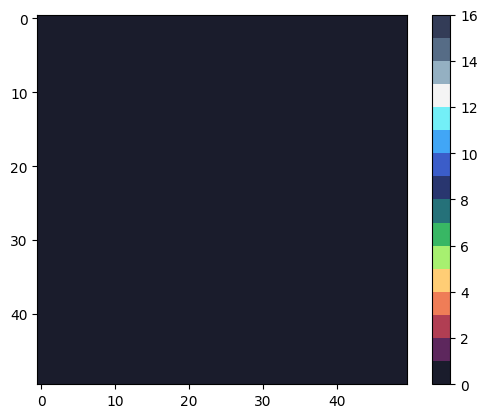

Start
[]


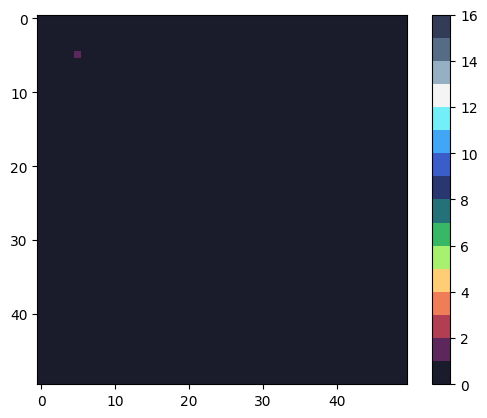

Right
[]


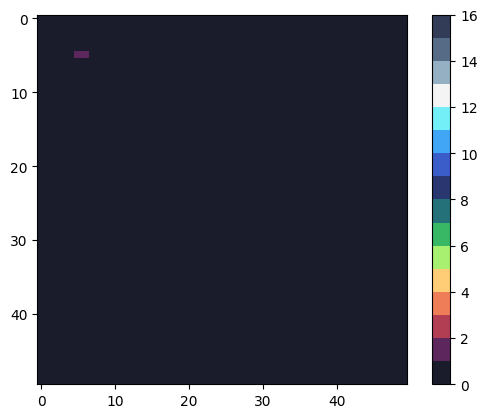

Down
[]


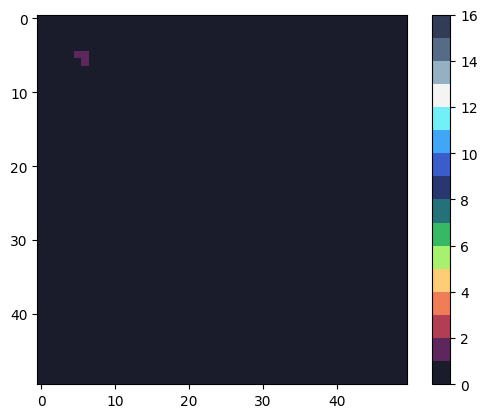

Right,S 10 Loop
[]


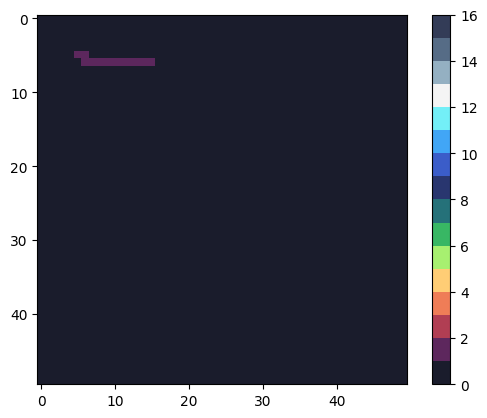

KeyboardInterrupt: ignored

In [ ]:
def REPL(M):

    while True:

        plt.imshow(M[D['DL']+1:D['DL']+n*n+1].reshape(n,n), cmap=color_map, vmin=0, vmax=colors)
        plt.colorbar()
        plt.show()
        plt.pause(0.1)

        program = input()

        if program == "Exit": break

        program = compile_program(program)

        M[D["PS"]:D["PS"] + len(program)] = program
        M[0] = D["PS"]

        M = run(M)


        print(M[D['SL']+1:D['SL']+1+M[D['SL']]])


program = "0"
M = setup(program)
REPL(M)

#Notes

In [ ]:
        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
        i,j = M[a]    , M[b]     # copy from address i paste in address j


        # Literal and Pointer
        if j == L:
            M[j] = i             # i is an address that is converted to a value

        elif i == P:
            M[j] = M[M[A]]       # copy from P uses address in A as source
        elif j == P:
            M[M[A]] = M[i]       # copy to P uses address in A as destination


        #Parameter Stack
        elif i == S:
            M[j] = M[SL + M[SL]]
            M[SL] -= 1
        elif j == S:
            M[SL] += 1
            M[SL + M[SL]] = M[i]


        #Return Stack
        elif i == W:
            M[j] = M[WL + M[WL]]
            M[WL] -= 1
        elif j == W:
            M[WL] += 1
            M[WL + M[WL]] = M[0]
            M[0] = M[i]


        #Default Move
        else:
            M[j] = M[i]


        #Memory Mapped ALU
        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]



In [ ]:
# new_code = '''
# TurtleX
# TurtleY
# TurtleI
# TurtleC
# TurtleN
# UpdateTurtleI TurtleX,S TurtleN,S *,W TurtleY,S +,W S,TurtleI W,0
# TurtleX-- TurtleX,S --,W S,TurtleX W,0
# TurtleX++ TurtleX,S ++,W S,TurtleX W,0
# TurtleY-- TurtleY,S --,W S,TurtleY W,0
# TurtleY++ TurtleY,S ++,W S,TurtleY W,0
# TurtleI++ TurtleI,S ++,W S,TurtleI W,0
# ^ TurtleI++,W W,0
# Paint S,A S,L L,P W,0
# Start 20,L L,TurtleN 5,L L,TurtleX 5,L L,TurtleY 700,L L,TurtleI 255,L L,TurtleC W,0
# Draw TurtleC,S TurtleI,S Paint,W W,0
# '''

In [ ]:


# Debug View
D2 = {v: k for k, v in D.items()} #invert D
for i in range(len(C)-2300):
    if i in D2:
        print(i,"  ",D2[i], C[i])
    else:
        print(i,"           ",C[i])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

N = 2500

def load_from_string(content):

    lines = content.strip().split("\n")

    C = np.zeros(N, dtype='object')
    D = {}
    i = 0

    for line in lines:

        tokens = line.strip().replace(',', ' ').split()

        D[tokens[0]] = i

        code = [D[token] if token in D else int(token) for token in tokens[1:]]

        if code:
            C[i] = i + 1
            C[i+1:i+1+len(code)] = code
            i += len(code) + 1
        else:
            i += 1

    return C, D



def compile_program(X):
    program = []
    for x in X.split(' '):
        if x.lstrip("-").isdigit():
            program += [int(x), D['L'], D['L'], D['S']]
        elif "," in x:
            a, b = map(lambda y: int(y) if y.lstrip("-").isdigit() else D[y], x.split(','))
            program += [a, b]
        else:
            program += [D[x], D['W']]
    program += [0, D['L'], D['L'], D['IP']]
    return program



def setup(program):
    program = compile_program(program)
    M = np.zeros(N, dtype=int)
    M[:len(C)] = C
    M[D["PS"]:D["PS"] + len(program)] = program
    M[D["IP"]] = D["PS"]
    M[D["SL"]] = 0
    M[D["WL"]] = 0
    return M



def run(M):

    IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])


    while M[IP] > 0:

        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1  # a is pointer to address i, b is pointer to address j
        i,j = M[a]    , M[b]     # copy from address i paste in address j


        # Literal and Pointer
        if j == L:
            M[j] = i             # i is an address that is converted to a value
        elif i == P:
            M[j] = M[M[A]]       # copy from P uses address in A as source
        elif j == P:
            M[M[A]] = M[i]       # copy to P uses address in A as destination


        #Parameter Stack
        elif i == S:
            M[j] = M[SL + M[SL]]
            M[SL] -= 1
        elif j == S:
            M[SL] += 1
            M[SL + M[SL]] = M[i]


        #Return Stack
        elif i == W:
            M[j] = M[WL + M[WL]]
            M[WL] -= 1
        elif j == W:
            M[WL] += 1
            M[WL + M[WL]] = M[0]
            M[0] = M[i]


        #Default Move
        else:
            M[j] = M[i]


        #Memory Mapped ALU
        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]


    return M



code_ai = """
IP
A
B
C
X
Y
Z
I
J
K
Add
Sub
Mult
Div
Equal
Greater
Lesser
L
S
W
P
Halt 0,L L,0
Push A,S W,0
Peek S,A A,S W,0
Pop S,A W,0
Drop S,C W,0
Dup S,A A,S A,S W,0
Swap S,B S,A B,S A,S W,0
Zero 0,L L,S W,0
One 1,L L,S W,0
+ S,B S,A Add,S W,0
- S,B S,A Sub,S W,0
* S,B S,A Mult,S W,0
/ S,B S,A Div,S W,0
Not S,A -1,L L,B Mult,A 1,L L,B Add,S W,0
Negate S,A -1,L L,B Mult,S W,0
Rot S,C S,B S,A C,S A,S B,S W,0
Continue A,A W,0
Branch Dup,W Not,W Rot,W *,W Rot,W *,W +,W S,A A,W W,0
If Continue,S Rot,W Branch,W W,0
Square Dup,W *,W W,0
Cube Dup,W Square,W *,W W,0
Fourth Square,W Square,W A,A W,0
Double Dup,W +,W W,0
-- S,A 1,L L,B Sub,S W,0
++ S,A 1,L L,B Add,S W,0
== S,B S,A Equal,S W,0
> S,B S,A Greater,S W,0
< S,B S,A Lesser,S W,0
Word1 Double,W W,0
Apple W,0
Orange W,0
! S,A S,P W,0
@ S,A P,S W,0
Halve S,A 2,L L,B Div,S W,0
Over S,B S,A A,S B,S A,S W,0
Mod S,Y S,X X,A Y,B Div,A Mult,B X,A Sub,S W,0
I-- I,S --,W S,I W,0
I++ I,S ++,W S,I W,0
I--Y0 I,S --,W S,I Y,0 W,0
Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0
SL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
WL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
DL 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
PS
"""


C, D = load_from_string(code_ai) # Codes, Dictionary


# Test data
number_test_programs = [(f"{i}", [i]) for i in range(100)]

for i, (program, expected_answer) in enumerate(number_test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

test_programs = [
    ("10 11 +", [21]),                                     # Add 10 and 11
    ("10 3 -", [7]),                                       # Subtract 3 from 10
    ("8 9 *", [72]),                                       # Multiply 8 by 9
    ("10 2 /", [5]),                                       # Divide 10 by 2
    ("10 3 >", [1]),                                       # Check if 10 is greater than 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("1 Not", [0]),                                        # Logical NOT of 1
    ("5 Fourth", [625]),                                   # Raise 5 to the power of 4
    ("8 9 * 7 + Fourth", [38950081]),                      # Multiply 8 and 9, add 7, and raise the result to the power of 4
    ("0 Not", [1]),                                        # Logical NOT of 0
    ("-5 Negate", [5]),                                    # Negate -5
    ("6 --", [5]),                                         # Decrement 6 by 1
    ("3 Double", [6]),                                     # Double the value 3
    ("3 5 -", [-2]),                                       # Subtract 5 from 3
    ("3 5 >", [0]),                                        # Check if 3 is greater than 5
    ("0 5 >", [0]),                                        # Check if 0 is greater than 5
    ("6 5 >", [1]),                                        # Check if 6 is greater than 5
    ("5 Double,S Fourth,S One Branch", [625]),             # Double 5, raise it to the power of 4, and branch based on 1 (true)
    ("5 Double,S Fourth,S Zero Branch", [10]),             # Double 5, raise it to the power of 4, and branch based on 0 (false)
    ("5 Continue,S Fourth,S One Branch 22 1 +", [625,23]), # Continue with operations, raise 5 to the power of 4, branch based on 1, add 22 and 1
    ("5 Apple !,W",[]),                                    # Store 5 in the memory location represented by "Apple"
    ("5,L L,S Apple,S !,W Apple,S @,W",[5]),               # Load 5 to stack, store it in "Apple", then retrieve it
    ("4 Halve", [2]),                                      # Divide 4 by 2
    ('2 4 + 3 -', [3]),                                    # Simple arithmetic
    ('2 2 2 2 2 + + + +', [10]),                           # Stacking operations
    ('5 2 * 10 /', [1]),                                   # Multiplication followed by division
    ('5 2 <', [0]),                                        # Lesser than check
    ('2 5 <', [1]),                                        # Lesser than check
    ('5 5 ==', [1]),                                       # Equality check
    ('5 3 ==', [0]),                                       # Non-equality check
    ('5 3 > 4 +', [5]),                                    # Greater than check with subsequent addition
    ('6 3 / 2 *', [4]),                                    # Division followed by multiplication
    ('2 5 > 3 4 + +', [7]),                                # Greater than check with subsequent operations
    ("10 3 Over", [10, 3, 10]),
    ("3 Cube", [27]),
    ("10 3 6 Rot", [6, 10, 3]),
    ("7 4 Mod", [3]),
    ("10 3 Mod", [1]),
    ("5 Continue,S Double,S One Branch", [10]),
    ("5 Double,S One If", [10]),
    ("5 Double,S Zero If", [5]),
    ("2 Word1,S 10 Loop", [1024]),
    ("2 Word1,S 8 Loop", [256])
    ]

for i, (program, expected_answer) in enumerate(test_programs):
    M = setup(program)
    M = run(M)
    answer = M[D['SL']+1:D['SL']+1+M[D['SL']]]
    assert np.array_equal(answer, np.array(expected_answer)), f'Test {program} failed. Expected {expected_answer}, but got {answer.tolist()}.'

print('All tests passed.')

In [ ]:

def run(M):

    IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])


    while M[IP] > 0:

        M[IP] += 2

        a,b = M[IP]-2 , M[IP]-1
        i,j = M[a]    , M[b]     #copy from i paste in j

        if j == L:
            M[j] = i

        elif i == S:
            M[j] = M[SL + M[SL]]
            M[SL] -= 1
        elif j == S:
            M[SL] += 1
            M[SL + M[SL]] = M[i]

        elif i == W:
            M[j] = M[WL + M[WL]]
            M[WL] -= 1
        elif j == W:
            M[WL] += 1
            M[WL + M[WL]] = M[0]
            M[0] = M[i]

        elif i == P:
            M[j] = M[M[A]]
        elif j == P:
            M[M[A]] = M[i]

        else:
            M[j] = M[i]



        M[Add]  = M[A] + M[B]
        M[Sub]  = M[A] - M[B]
        M[Mult] = M[A] * M[B]
        M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

        M[Equal]   = M[A] == M[B]
        M[Greater] = M[A] > M[B]
        M[Lesser]  = M[A] < M[B]

    return M

In [ ]:
# def run(M):

#     IP, A, B, C, Add, Sub, Mult, Div, L, P, S, SL, W, WL, Equal, Greater, Lesser = (D[x] for x in ["IP", "A", "B", "C", "Add", "Sub", "Mult", "Div", "L", "P", "S", "SL", "W", "WL", "Equal", "Greater", "Lesser"])

#     while M[IP] > 0:

#         M[IP] += 2

#         a,b = M[IP]-2 , M[IP]-1
#         i,j = M[a]    , M[b]     #copy from i paste in j

#         if i == S and j == L:
#             M[L] = i
#         elif i == W and j == L:
#             M[L] = i

#         elif j == L:
#             M[L] = i

#         elif i == S:
#             M[j] = M[SL + M[SL]]
#             M[SL] -= 1
#         elif j == S:
#             M[SL] += 1
#             M[SL + M[SL]] = M[i]

#         elif i == W:
#             M[j] = M[WL + M[WL]]
#             M[WL] -= 1
#         elif j == W:
#             M[WL] += 1
#             M[WL + M[WL]] = M[0]
#             M[0] = M[i]

#         elif i == P:
#             M[j] = M[M[A]]
#         elif j == P:
#             M[M[A]] = M[i]

#         else:
#             M[j] = M[i]

#         M[Add]  = M[A] + M[B]
#         M[Sub]  = M[A] - M[B]
#         M[Mult] = M[A] * M[B]
#         M[Div]  = 0 if M[B] == 0 else M[A] // M[B]

#         M[Equal]   = M[A] == M[B]
#         M[Greater] = M[A] > M[B]
#         M[Lesser]  = M[A] < M[B]

#     return M


In [ ]:
# Save_Point
# IP,Y

# Jump_to_Save_Point
# Y,IP

In [ ]:
# 1 273 10

# Loop, looks for count on tos and address after

# Save count to I
# S,I

# Save word address on stack to X to run later
# S,X

# Save spot to go back later
# IP,Y

#Run word
#X,W

# Copy I to S and if > 0 then (I--_Y,S) else Continue


I--Y0 I,S --,W S,I Y,0 W,0
Loop S,I I--,W S,X IP,Y X,W Continue,S I--Y0,S I,S One,W >,W Branch,W W,0

In [ ]:
#Add Numbers
M = np.zeros(500, dtype=int)    #Memory

P = [100,1,101,2,4,1,102,2,4,1,103,2,4,1,104,2,4,50]     #add data from mem loc 100 to 104
# P = [100,1,101,2,6,1,102,2,6,1,103,2,6,1,104,2,6,50]   #mult data from mem loc 100 to 104

M[0:len(P)] = P
M[100:105] = [1,2,3,4,5]  #Data

# The Machine #
# while M[M[M[0]]] > -1:
for i in range(len(P)):
    #programLocation = M[0]
    #indexAtProgramLocation = M[M[0]]
    #valueAtIndexAtProgramLocation = M[M[M[0]]]

    M[M[M[0] + 1]] = M[M[M[0]]] #Move A to B

    M[4] = M[1] + M[2]
    M[5] = M[1] - M[2]
    M[6] = M[1] * M[2]
    M[7] = M[1] / M[2] if M[2] != 0 else 0
    M[8] = M[1] == M[2]
    M[9] = M[1] < M[2]
    M[10] = M[1] > M[2]
    M[0] = M[0] + 2 #Move Inst Counter

In [ ]:
while np.prod(M[:,0] >= 0) == 1:

    M[:,0] += 2

    A = M[:,M[:,0]-2]
    B = M[:,M[:,0]-1]

    M[:,B] = M[:,A]

    M[:,4]  = M[:,1] + M[:,2]
    M[:,5]  = M[:,1] - M[:,2]
    M[:,6]  = M[:,1] * M[:,2]
    M[:,7]  = np.where(M[:,2]!=0,M[:,1] // M[:,2],0)                        #M[:,1] // M[:,2] if M[:,2]!=0 else 0
    M[:,8]  = (M[:,1] > M[:,2]).astype(int)
    M[:,9]  = (M[:,1] < M[:,2]).astype(int)
    M[:,10] = (M[:,1] == M[:,2]).astype(int)
    M[:,11] = np.minimum(M[:,1],M[:,2]).astype(int)
    M[:,12] = np.maximum(M[:,1],M[:,2]).astype(int)
    M[:,13] = ~M[:,1]
    M[:,14] = M[:,1]^M[:,2]
    M[:,15] = np.where(M[:,3],M[:,1],M[:,2])                                #M[:,1] if M[:,3] else M[:,2]

In [ ]:
from flask import Flask, request, escape
import numpy as np

app = Flask(__name__)

FIXED_LENGTH = 100
arr = np.full((FIXED_LENGTH,), ord(' '), dtype=int)

@app.route('/', methods=['GET', 'POST'])
def index():
    if request.method == 'POST':
        # Convert input text to numpy array of ASCII values
        text = request.form.get('text_input')
        ascii_vals = [ord(char) for char in text.ljust(FIXED_LENGTH)[:FIXED_LENGTH]]

        global arr
        arr = np.array(ascii_vals)

    # Convert numpy array to ASCII string for display
    content = ''.join(chr(i) for i in arr)

    # HTML form for user input
    form_html = f'''
    <form method="post">
        <textarea name="text_input" rows="4" cols="50"></textarea><br>
        <input type="checkbox" name="debug" value="on"> Debug Mode<br>
        <input type="submit" value="Update"><br><br>
        <br>Rendered Content:<br>
        {content}
    </form>
    '''

    debug_output = ""
    if "debug" in request.form:
        # Display the numpy array, the raw ASCII, and the rendered HTML content
        debug_output = f'''
        <br>Integer Values:<br><br>
        {', '.join(map(str, arr))}<br>
        <br>Raw ASCII:<br>
        <pre><code>{escape(content)}</code></pre>
        '''



    return form_html + debug_output



app.run(host="0.0.0.0", port=8080, debug=True)


In [ ]:
# x = i/n
# y = i mod n
# i = x*n+y

In [ ]:
# https://www.dafont.com/img/charmap/r/e/retro_computer0.png